# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 5 - Równania nieliniowe
### Albert Gierlach

### 0. Funkcje do testów

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
from mpmath import *
import inspect
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mtplt

mtplt.rcParams['figure.figsize'] = [14, 7] # plots size

functions = [
    {
        "func": lambda x: (cos(x) * cosh(x)) - 1,
        "func_der": lambda x: (cos(x) * sinh(x)) - (cosh(x) * sin(x)),
        "left_bound": (3 / 2) * pi,
        "right_bound": 2 * pi,
    },
    {
        "func": lambda x: (1 / x) * tan(x),
        "func_der": lambda x: ((x * power(sec(x), 2)) - tan(x)) / power(x, 2),
        "left_bound": 0,
        "right_bound": pi / 2,
    },
    {
        "func": lambda x: power(2, -x) + power(e, x) + 2 * cos(x) - 6,
        "func_der": lambda x: power(e, x) - (power(2, -x) * log(2)) - (2 * sin(x)),
        "left_bound": 1,
        "right_bound": 3,
    }
]

#### 1. Metoda bisekcji

In [3]:
def get_max_iter(a, b, eps):
    return int(ceil(log((b - a) / eps) / log(2)))


def safe_calc(f, a):
    try:
        return f(a)
    except ZeroDivisionError:
        return inf
    
def bisection(func, eps, precision, silent=False):
    mp.dps = precision
    f, a, b = func['func'], func['left_bound'], func['right_bound']
    fa, fb = safe_calc(f, a), safe_calc(f, b)

    iter = 0
    error = mpf(b - a)

    if fa == 0:
        return a, f(a), iter
    elif fb == 0:
        return b, f(b), iter
    elif fa * fb > 0:  # same signs
        if not silent:
            print("Function does not have root in range [{};{}]".format(a, b))
        return None
    else:
        for n in range(get_max_iter(a, b, eps)):
            iter += 1
            error /= 2
            c = a + error
            fc = f(c)
            if fabs(error) < eps:
                return c, f(c), iter

            if fa * fc >= 0:
                a = c
                fa = fc


Function: (cos(x) * cosh(x)) - 1

Precision: 7
Root at 4.730041, value -9.164214e-7, iterations 24

Precision: 15
Root at 4.7300407448627, value 3.574918139293e-14, iterations 51

Precision: 33
Root at 4.73004074486270402602404810083389, value 4.00593428432545057435643412057665e-32, iterations 111


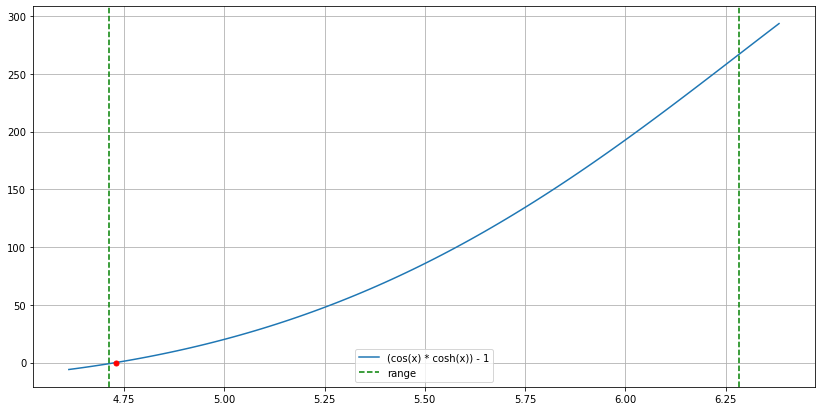



Function: (1 / x) * tan(x)

Precision: 7
Function does not have root in range [0;1.570796]

Precision: 15
Function does not have root in range [0;1.5707963267949]

Precision: 33
Function does not have root in range [0;1.57079632679489655799898173427209]


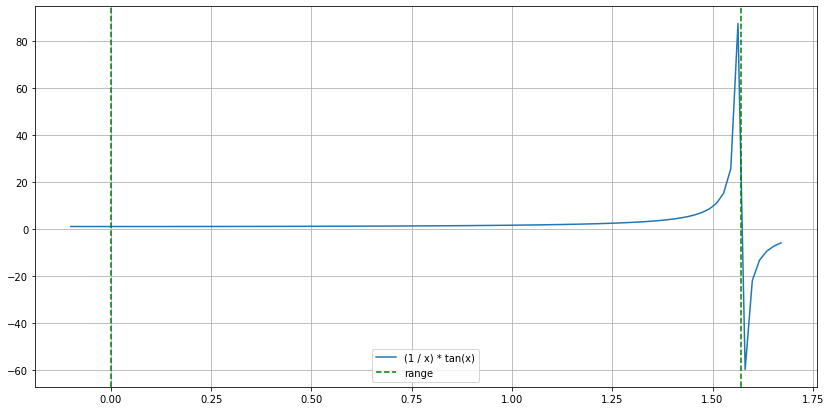



Function: power(2, -x) + power(e, x) + 2 * cos(x) - 6

Precision: 7
Root at 1.829384, value -1.788139e-7, iterations 25

Precision: 15
Root at 1.82938360193385, value 1.77635683940025e-15, iterations 51

Precision: 33
Root at 1.82938360193384881713621294681415, value 0.0, iterations 111


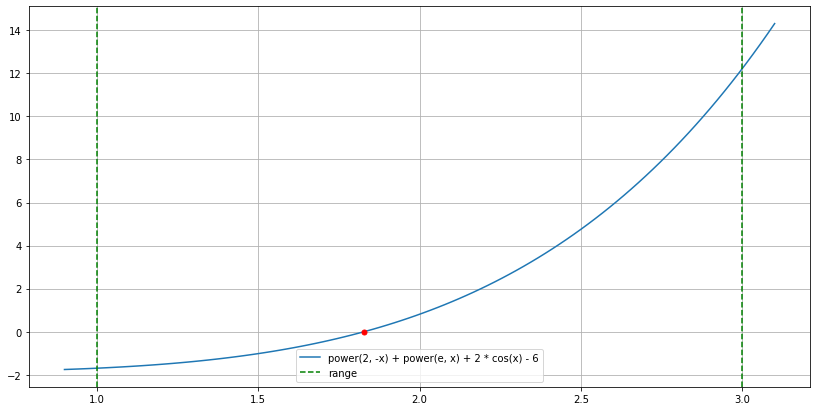

In [4]:
bound_correct = 0.1
epsilon = [mpf(1e-7), mpf(1e-15), mpf(1e-33)]
precision = [7, 15, 33]
for f in functions:
    fname = inspect.getsourcelines(f['func'])[0][0].split(':')[2].strip()[:-1]
    print("\nFunction: " + fname)
    ret = None
    for i in range(len(precision)):
        print("\nPrecision: {}".format(precision[i]))
        ret = bisection(f, epsilon[i], precision[i])
        if ret is not None:
            print("Root at {}, value {}, iterations {}".format(ret[0], ret[1], ret[2]))


    x = np.linspace(np.float32(f['left_bound']) - bound_correct, np.float32(f['right_bound']) + bound_correct, 100)
    plt.plot(x, [f['func'](_x) for _x in x], label=fname)
    plt.axvline(np.float32(f['left_bound']), color="green", label="range", linestyle="--")
    plt.axvline(np.float32(f['right_bound']), color="green", linestyle="--")
    if ret is not None:
        plt.plot([ret[0]], [f['func'](ret[0])], marker='o', markersize=5, color="red")
    plt.legend()
    plt.grid()
    plt.show()
    print()

#### W jaki sposób możemy obliczyć k pierwszych dodatnich pierwiastków funkcji f1(x)?
Możemy iterować po przedziale [0, N], aż nie uzyskamy k pierwiastków.

In [5]:
def get_k_roots(f, k):
    roots = []
    i = 0
    prec, eps = 15, mpf(1e-15)
    f_dict = {
        "func": f,
        "left_bound": 0,
        "right_bound": 2
    }
    while i < k:
        res = bisection(f_dict, eps, prec, True)
        if res is not None:
            roots.append(res[0])
            i += 1

        f_dict['left_bound'] = f_dict['right_bound']
        f_dict['right_bound'] += 2

    return roots

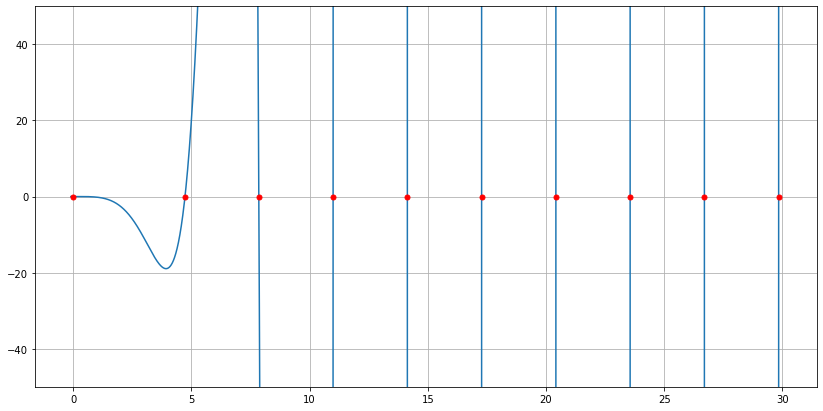

In [6]:
k = 10
f = functions[0]
roots = get_k_roots(f['func'], k)
x = np.linspace(0 - bound_correct, np.float32(roots[-1]) + bound_correct, 10000)
plt.plot(x, [f['func'](_x) for _x in x])
for r in roots:
    plt.plot([r], [f['func'](r)], marker='o', markersize=5, color="red")
plt.ylim(-50, 50)
plt.grid()
plt.show()

### 2. Metoda Newtona

In [7]:
def newton(func, eps, precision):
    mp.dps = precision
    f, x = func['func'], func['left_bound']
    fx = safe_calc(f, x)
    delta = mpf(1e-20)

    for i in range(get_max_iter(func['left_bound'], func['right_bound'], eps)):
        fp = mpf(safe_calc(func['func_der'], x))
        if fabs(fp) < delta:
            return None

        d = mpf(fx/fp)
        x -= d
        fx = f(x)
        if fabs(d) < eps:
            return x, f(x), i

    print("No root found. Max steps reached")


Function: (cos(x) * cosh(x)) - 1

Precision: 7
Root at 4.730041, value -9.164214e-7, iterations 3

Precision: 15
Root at 4.7300407448627, value -1.53210777398272e-14, iterations 4

Precision: 33
Root at 4.73004074486270402602404810083388, value -4.33334237487128066937595037081609e-33, iterations 5


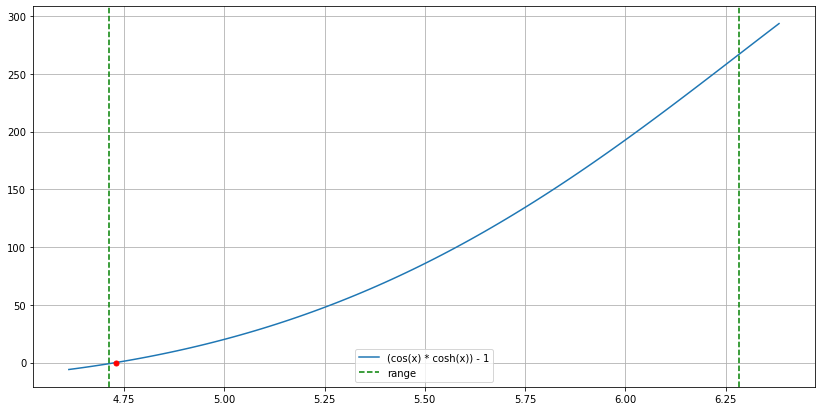


Function: (1 / x) * tan(x)

Precision: 7
No root found. Max steps reached

Precision: 15
No root found. Max steps reached

Precision: 33
No root found. Max steps reached


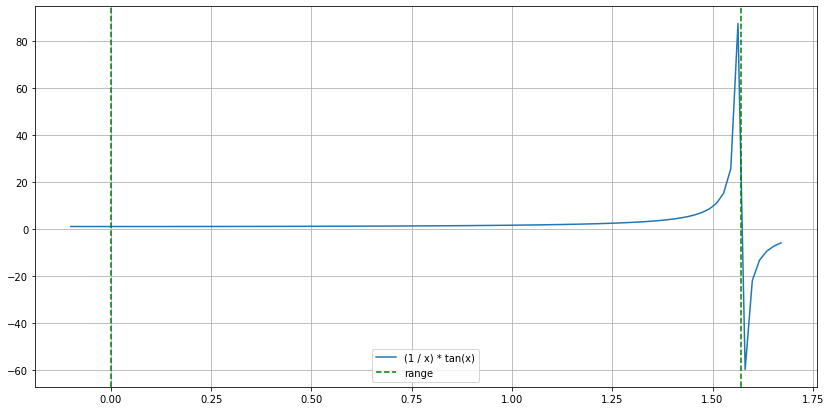


Function: power(2, -x) + power(e, x) + 2 * cos(x) - 6

Precision: 7
Root at 1.829384, value 0.0, iterations 7

Precision: 15
Root at 1.82938360193385, value 0.0, iterations 8

Precision: 33
Root at 1.82938360193384881713621294681415, value 0.0, iterations 9


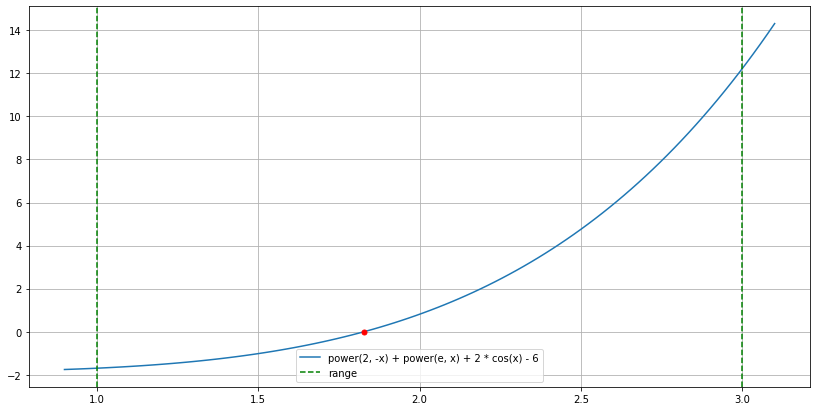

In [8]:
bound_correct = 0.1
epsilon = [mpf(1e-7), mpf(1e-15), mpf(1e-33)]
precision = [7, 15, 33]
for f in functions:
    fname = inspect.getsourcelines(f['func'])[0][0].split(':')[2].strip()[:-1]
    print("\nFunction: " + fname)
    ret = None
    for i in range(len(precision)):
        print("\nPrecision: {}".format(precision[i]))
        ret = newton(f, epsilon[i], precision[i])
        if ret is not None:
            print("Root at {}, value {}, iterations {}".format(ret[0], ret[1], ret[2]))

    #this really should be a function
    x = np.linspace(np.float32(f['left_bound']) - bound_correct, np.float32(f['right_bound']) + bound_correct, 100)
    plt.plot(x, [f['func'](_x) for _x in x], label=fname)
    plt.axvline(np.float32(f['left_bound']), color="green", label="range", linestyle="--")
    plt.axvline(np.float32(f['right_bound']), color="green", linestyle="--")
    if ret is not None:
        plt.plot([ret[0]], [f['func'](ret[0])], marker='o', markersize=5, color="red")
    plt.legend()
    plt.grid()
    plt.show()

**Metoda Newtona osiąga znacznie lepsze wyniki niż metoda bisekcji. Znalezione pierwiastki są niemal identyczne, ale liczba iteracji potrzebna do ich wyliczenia różni się znacząco. Metoda Newtona jest znacznie efektywniejsza pod względem potrzebnych iteracji. Wadą może być to, iż potrzebujemy pochodnej funkcji**

### 3. Metoda siecznych

In [9]:
def secant(func, eps, precision):
    mp.dps = precision
    f, a, b = func['func'], func['left_bound'], func['right_bound']
    fa, fb = safe_calc(f, a), safe_calc(f, b)

    if fa * fb > 0:  # same signs
        print("Function does not have root in range [{};{}]".format(a, b))
        return None

    if fabs(fa) > fabs(fb):
        a, b = b, a
        fa, fb = fb, fa

    for i in range(2, get_max_iter(func['left_bound'], func['right_bound'], eps), 1):
        if fabs(fa) > fabs(fb):
            a, b = b, a
            fa, fb = fb, fa

        d = mpf((b - a) / (fb - fa))
        b = a
        fb = fa
        d *= fa
        if fabs(d) < eps:
            return a, f(a), i

        a -= d
        fa = f(a)


    print("No root found. Max steps reached")


Function: (cos(x) * cosh(x)) - 1

Precision: 7
Root at 4.730041, value -9.164214e-7, iterations 6

Precision: 15
Root at 4.7300407448627, value -1.53210777398272e-14, iterations 8

Precision: 33
Root at 4.73004074486270402602404810083388, value -4.33334237487128066937595037081609e-33, iterations 9


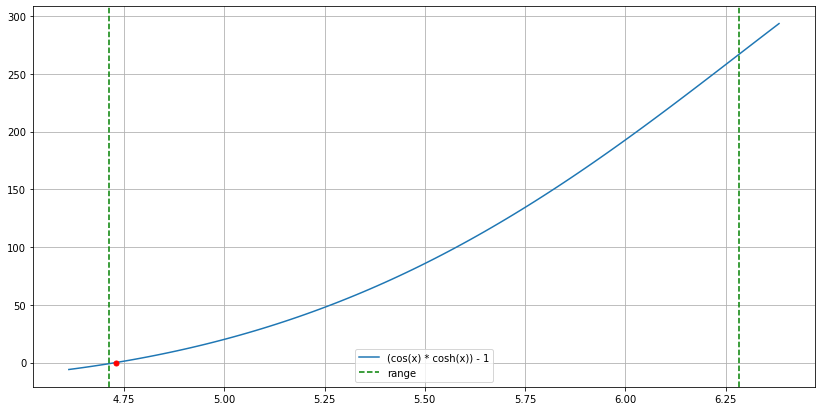


Function: (1 / x) * tan(x)

Precision: 7
Function does not have root in range [0;1.570796]

Precision: 15
Function does not have root in range [0;1.5707963267949]

Precision: 33
Function does not have root in range [0;1.57079632679489655799898173427209]


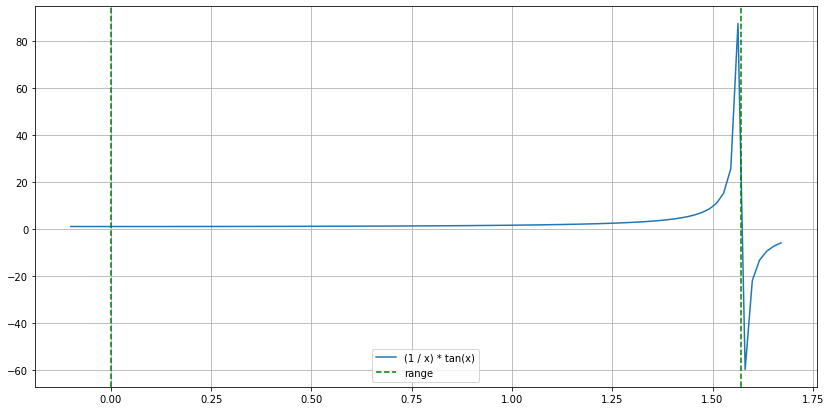


Function: power(2, -x) + power(e, x) + 2 * cos(x) - 6

Precision: 7
Root at 1.829384, value -5.960464e-8, iterations 12

Precision: 15
Root at 1.82938360193385, value 0.0, iterations 13

Precision: 33
Root at 1.82938360193384881713621294681415, value 0.0, iterations 15


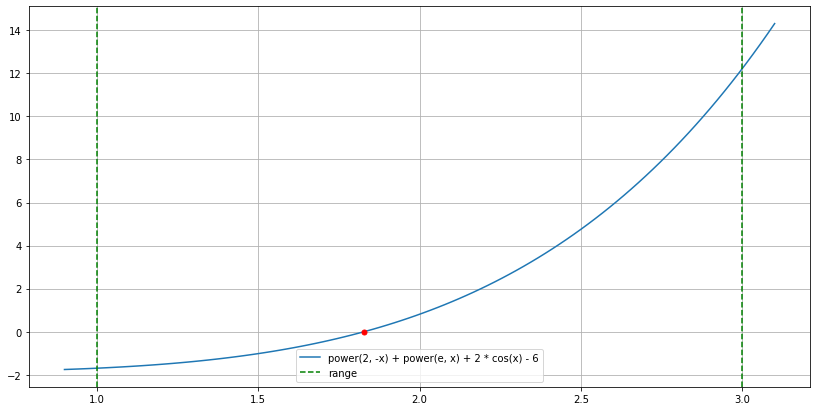

In [10]:
bound_correct = 0.1
epsilon = [mpf(1e-7), mpf(1e-15), mpf(1e-33)]
precision = [7, 15, 33]
for f in functions:
    fname = inspect.getsourcelines(f['func'])[0][0].split(':')[2].strip()[:-1]
    print("\nFunction: " + fname)
    ret = None
    for i in range(len(precision)):
        print("\nPrecision: {}".format(precision[i]))
        ret = secant(f, epsilon[i], precision[i])
        if ret is not None:
            print("Root at {}, value {}, iterations {}".format(ret[0], ret[1], ret[2]))

    x = np.linspace(np.float32(f['left_bound']) - bound_correct, np.float32(f['right_bound']) + bound_correct, 100)
    plt.plot(x, [f['func'](_x) for _x in x], label=fname)
    plt.axvline(np.float32(f['left_bound']), color="green", label="range", linestyle="--")
    plt.axvline(np.float32(f['right_bound']), color="green", linestyle="--")
    if ret is not None:
        plt.plot([ret[0]], [f['func'](ret[0])], marker='o', markersize=5, color="red")
    plt.legend()
    plt.grid()
    plt.show()

**Jak pokazały przedstawione obliczenia wszystkie trzy metody zwracają poprawne pierwiastki (lub ich brak) dla wszystkich trzech funkcji. Metoda siecznych wymaga nieco więcej iteracji niż metoda Newtona, ale nie wymaga za to wiedzy o pochodnej funkcji, co może być przewagą przy skompli **